In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', None)
pd.set_option('future.no_silent_downcasting', True)
sns.set()

df = pd.read_csv('data_part_2.csv')

print(df.shape)
df.head()

(1009, 18)


,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,final_price,time_of_day,sold
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,night,1
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,NaN,morning,0
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,NaN,night,0
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,NaN,evening,0
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,NaN,day,0


# Set Proper Data Types

In [2]:
dtype_mapping = {
    'user_id': 'int64', 
    'region': 'object', 
    'device': 'object', 
    'channel': 'object', 
    'session_start': 'datetime64[ns]', 
    'session_end': 'datetime64[ns]', 
    'sessiondurationsec': 'float64', 
    'session_date': 'datetime64[ns]', 
    'month': 'int64', 
    'day': 'int64', 
    'hour_of_day': 'int64', 
    'order_dt': 'datetime64[ns]', 
    'revenue': 'float64', 
    'payment_type': 'object', 
    'promo_code': 'float64'
}

df = df.astype(dtype_mapping)

# Custom Functions 1

In [97]:
def aggregate_daily_purchases(
    data: pd.DataFrame,
    group_cols: List[str] = ['region', 'device'],
    date_col: str = 'session_date',
    target_col: str = 'sold'
) -> pd.DataFrame:
    daily_purchases = (data
                      .groupby([date_col] + group_cols)[target_col]
                      .sum()
                      .reset_index())
    
    return daily_purchases

def plot_purchase_distribution(
    data: pd.DataFrame,
    group_cols: List[str] = ['region', 'device'],
    target_col: str = 'sold',
    plot_type: str = 'bar',
    normalize: Optional[str] = None,  # None, 'row', 'column', 'total'
    add_labels: bool = False,
    figsize: tuple = (12, 6)
) -> None:
    """
    Creates a plot showing purchases distribution across grouping categories.
    
    Parameters
    ----------
    data : pd.DataFrame
        Aggregated daily purchase data
    group_cols : List[str]
        Columns to group by (e.g., ['region', 'device'])
    target_col : str
        Column containing purchase counts
    plot_type : str
        Type of plot ('bar' or 'heatmap')
    normalize : str or None
        How to normalize the data:
        - None: use absolute values
        - 'row': normalize by row (each row sums to 100%)
        - 'column': normalize by column (each column sums to 100%)
        - 'total': normalize by total (all values sum to 100%)
    add_labels : bool
        Whether to add value labels on bars (for bar plot only)
    figsize : tuple
        Figure size (width, height)
    """
    # Aggregate total purchases
    total_purchases = data.groupby(group_cols)[target_col].sum().reset_index()
    
    # Create pivot table for normalization
    pivot_data = total_purchases.pivot(
        index=group_cols[0],
        columns=group_cols[1],
        values=target_col
    )
    print(pivot_data)
    
    # Apply normalization if requested
    if normalize:
        if normalize == 'row':
            pivot_data = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100
            value_fmt = '.1f'
            ylabel = 'Percentage of Region Purchases'
        elif normalize == 'column':
            pivot_data = pivot_data.div(pivot_data.sum(axis=0)) * 100
            value_fmt = '.1f'
            ylabel = 'Percentage of Device Purchases'
        elif normalize == 'total':
            pivot_data = pivot_data.div(pivot_data.sum().sum()) * 100
            value_fmt = '.1f'
            ylabel = 'Percentage of Total Purchases'
        else:
            raise ValueError("normalize must be one of: None, 'row', 'column', 'total'")
    else:
        value_fmt = '.0f'
        ylabel = 'Total Purchases'
    
    plt.figure(figsize=figsize)
    
    if plot_type == 'bar':
        # Convert back to long format for bar plot
        plot_data = pivot_data.reset_index().melt(
            id_vars=group_cols[0],
            var_name=group_cols[1],
            value_name=target_col
        )
        
        # Create grouped bar plot
        ax = sns.barplot(
            data=plot_data,
            x=group_cols[1],
            y=target_col,
            hue=group_cols[0],
            palette='Set2'
        )
        
        if add_labels:
            for container in ax.containers:
                ax.bar_label(container, fmt=f'%{value_fmt}', padding=3)
            ax.set_ylim(0, ax.get_ylim()[1] * 1.1)
            
        plt.title(f'{"Normalized " if normalize else ""}Purchases by {group_cols[1]} and {group_cols[0]}', pad=20)
        plt.xlabel(group_cols[1])
        plt.ylabel(ylabel)
        
    elif plot_type == 'heatmap':
        # Create heatmap
        sns.heatmap(
            pivot_data,
            annot=True,
            fmt=value_fmt,
            cmap='YlOrRd',
            cbar_kws={'label': ylabel}
        )
        
        plt.title(f'{"Normalized " if normalize else ""}Purchases Heatmap: {group_cols[0]} vs {group_cols[1]}', pad=20)
    
    plt.tight_layout()

# Purchases By Device And Region

In [96]:
agg_df = aggregate_daily_purchases(df)

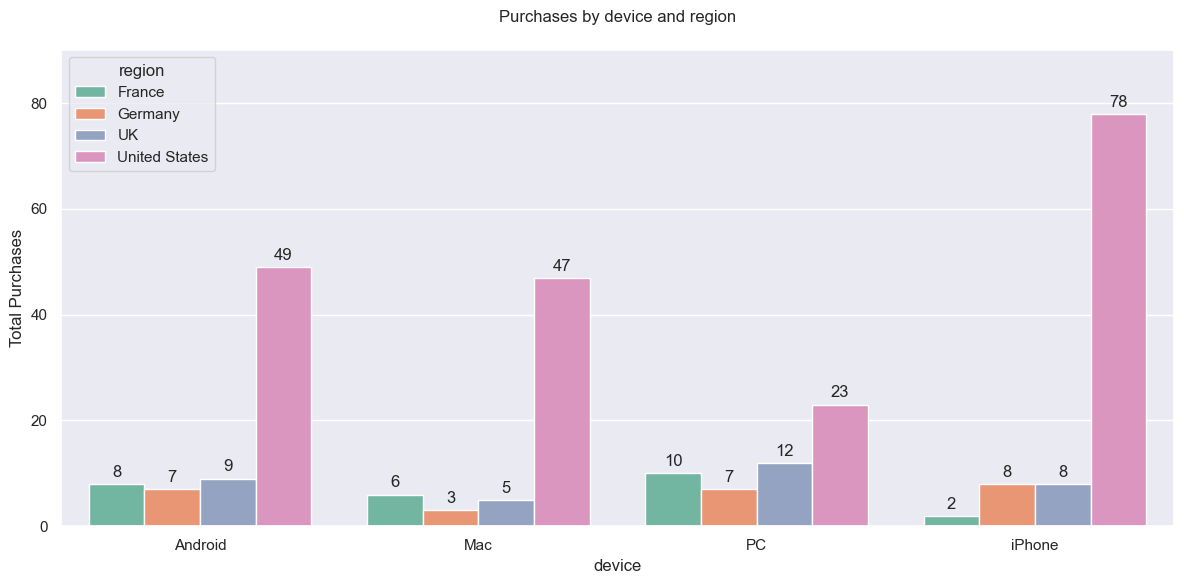

In [45]:
plot_purchase_distribution(agg_df, add_labels=True)

device         Android  Mac  PC  iPhone
region                                 
France               8    6  10       2
Germany              7    3   7       8
UK                   9    5  12       8
United States       49   47  23      78


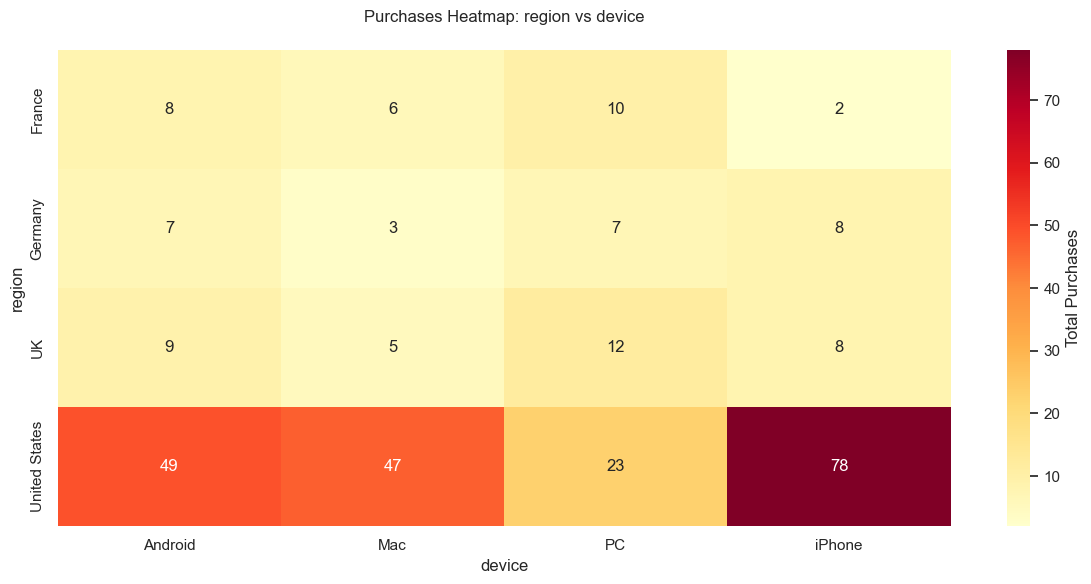

In [99]:
agg_df = aggregate_daily_purchases(df)
plot_purchase_distribution(agg_df, plot_type='heatmap')

# Custom Functions 2

In [79]:
def plot_purchase_distribution_analysis(
    data: pd.DataFrame,
    group_cols: List[str] = ['region', 'device'],
    target_col: str = 'sold',
    time_period: str = 'monthly',  # 'daily', 'weekly', 'monthly'
    plot_type: str = 'box',
    use_facets: bool = False,
    figsize: tuple = (15, 8)
) -> None:
    """
    Creates distribution plots using temporal aggregation.
    
    Parameters
    ----------
    data : pd.DataFrame
        Daily purchase data
    group_cols : List[str]
        Columns to group by. First element will be used for faceting/hue,
        second element for x-axis
    target_col : str
        Column containing purchase counts
    time_period : str
        Temporal aggregation level ('daily', 'weekly', 'monthly')
    plot_type : str
        Type of plot ('box' or 'violin')
    use_facets : bool
        Whether to use FacetGrid (True) or single plot (False)
    figsize : tuple
        Figure size
    """
    # Temporal aggregation
    if time_period == 'weekly':
        data['period'] = pd.to_datetime(data['session_date']).dt.isocalendar().week
    elif time_period == 'monthly':
        data['period'] = pd.to_datetime(data['session_date']).dt.month
    else:  # daily
        data['period'] = data['session_date']
    
    # Aggregate by period and grouping columns
    agg_data = (data.groupby(['period'] + group_cols)[target_col]
                .sum()
                .reset_index())
    
    if use_facets:
        # Create FacetGrid using first grouping column
        g = sns.FacetGrid(
            data=agg_data,
            col=group_cols[0],  # first group col for faceting
            col_wrap=2,
            height=figsize[1]/2,
            aspect=1.5
        )
        
        # Map the plot function using second grouping column for x-axis
        if plot_type == 'box':
            g.map_dataframe(
                sns.boxplot,
                x=group_cols[1],  # second group col for x-axis
                y=target_col,
                color='skyblue'
            )
        else:  # violin
            g.map_dataframe(
                sns.violinplot,
                x=group_cols[1],
                y=target_col,
                color='skyblue'
            )
        
        g.figure.suptitle(
            f'{time_period.capitalize()} Purchase Distribution by {group_cols[1]} and {group_cols[0]}',
            y=1.02
        )
        
        for ax in g.axes.flat:
            ax.tick_params(axis='x', rotation=45)
            
    else:
        # Single plot with all data
        plt.figure(figsize=figsize)
        
        if plot_type == 'box':
            sns.boxplot(
                data=agg_data,
                x=group_cols[1],     # second group col for x-axis
                y=target_col,
                hue=group_cols[0],   # first group col for hue
                palette='Set2'
            )
        else:  # violin
            sns.violinplot(
                data=agg_data,
                x=group_cols[1],     # second group col for x-axis
                y=target_col,
                hue=group_cols[0],   # first group col for hue
                palette='Set2'
            )
            
        plt.title(f'{time_period.capitalize()} Purchase Distribution by {group_cols[1]} and {group_cols[0]}')
        plt.xticks(rotation=45)
        
    plt.tight_layout()

# Purchase Distribution

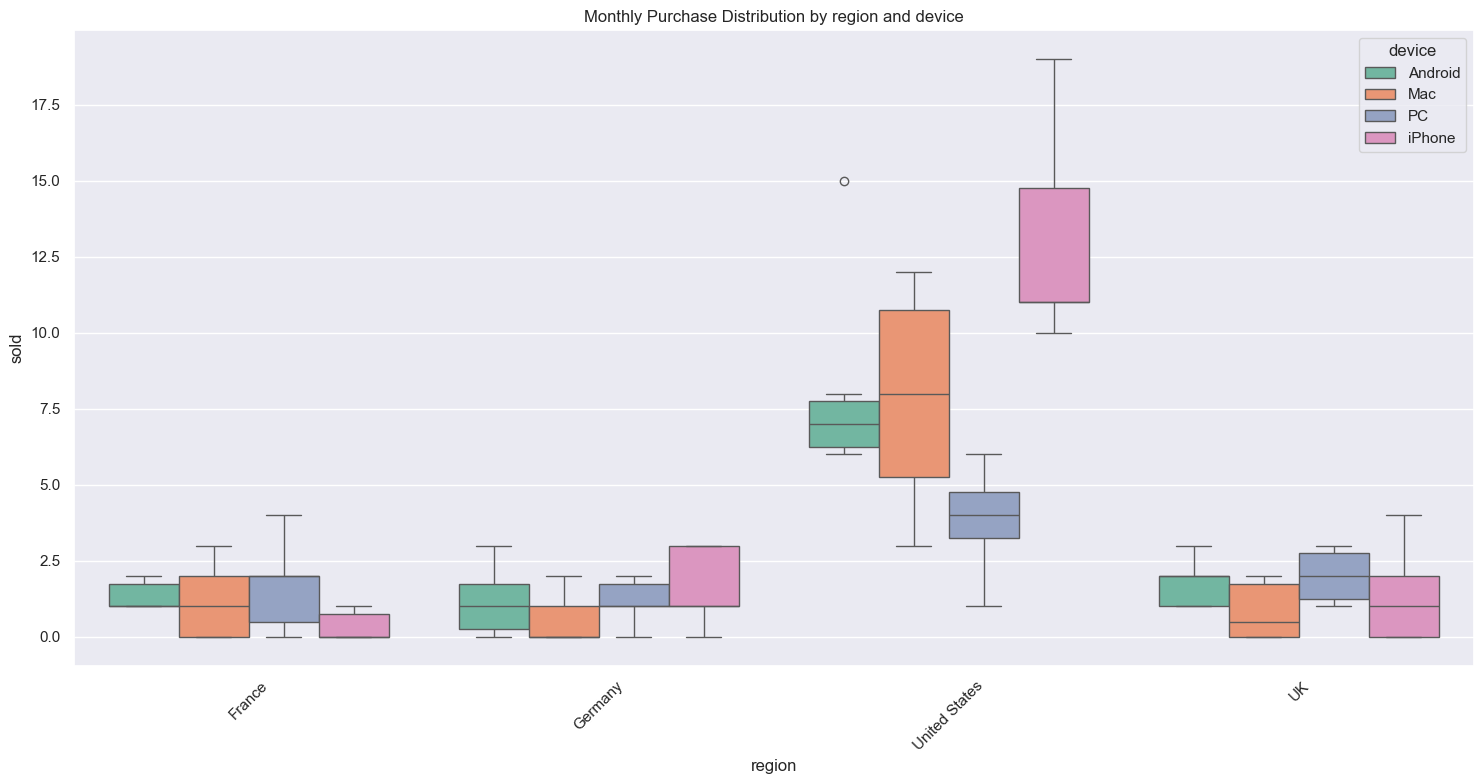

In [80]:
plot_purchase_distribution_analysis(agg_df, group_cols=['device', 'region'], plot_type='box')

# 

# 